In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import sys
print(sys.version)

In [ ]:
#first install 

!pip install torch==2.3.1 

In [ ]:
import torch
print(torch.__version__)

In [ ]:
!pip install torchvision>=0.18.1

In [2]:
#if you are using a notebook restart kernel after installing or unistalling any library

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.4.0+cu121
0.19.0+cu121


In [ ]:
# if torchvision>=0.18.1 is not installed then do this else skip this part and try to install "!pip install torchvision>=0.18.1 --upgrade --force-reinstall --no-deps" again 
!pip uninstall fastai -y
!pip install torchvision>=0.18.1 --upgrade --force-reinstall --no-deps

In [ ]:
#check the version again
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git

In [ ]:
!pip install -e /kaggle/working/segment-anything-2

In [ ]:
!cd /kaggle/working/segment-anything-2/checkpoints && ./download_ckpts.sh && cd ..

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [4]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "/kaggle/working/segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [8]:
!rm -rf /kaggle/working/output_dir/

In [9]:
!mkdir -p /kaggle/working/output_dir/

In [10]:
!ffmpeg -i /kaggle/input/vechile-data/854745-hd_1280_720_50fps.mp4 -q:v 2 -start_number 0 -frames:v 100 /kaggle/working/output_dir/%05d.jpg

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

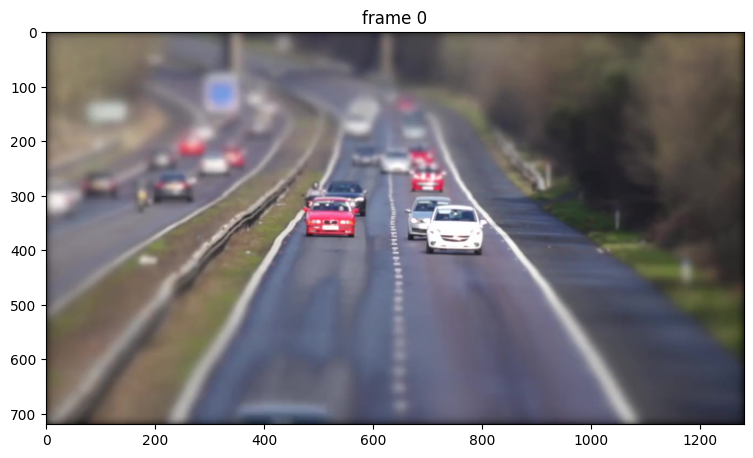

In [11]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/kaggle/working/output_dir"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [12]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 100/100 [00:03<00:00, 28.55it/s]


In [14]:
predictor.reset_state(inference_state)

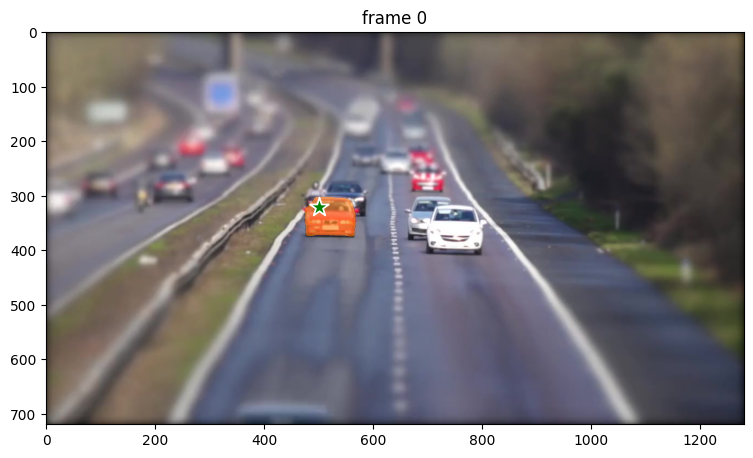

In [17]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[500, 320]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

propagate in video: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


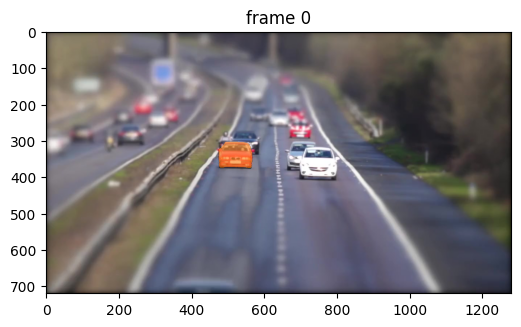

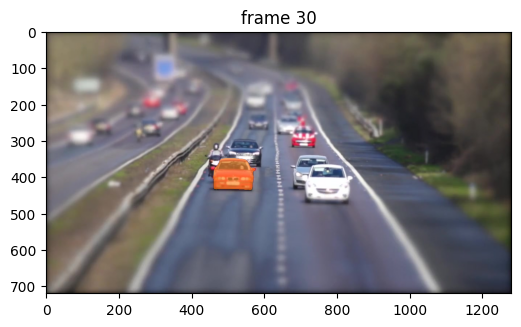

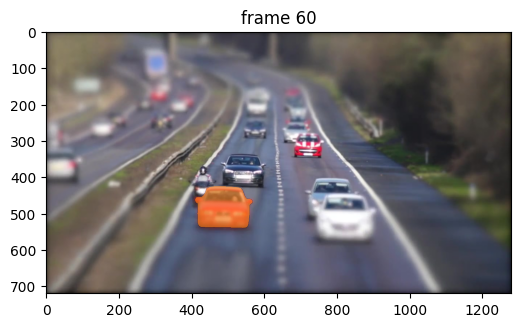

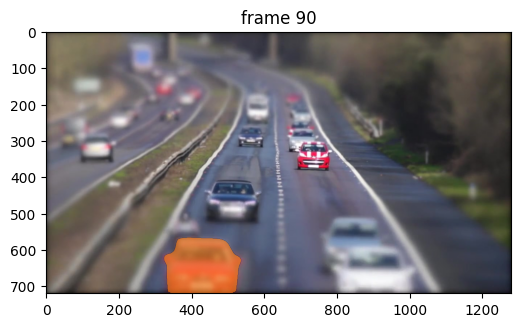

In [28]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [22]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }


propagate in video: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


In [26]:
import os
import cv2
import numpy as np
from PIL import Image

# Create a directory to save individual frames
frames_dir = "/kaggle/working/segmented_frames"
os.makedirs(frames_dir, exist_ok=True)

# Iterate over all frames and save each as an image
for out_frame_idx in range(len(frame_names)):
    img = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
    img = np.array(img)
    
    # Create a figure and add segmentation masks
    plt.figure(figsize=(6, 4))
    plt.imshow(img)
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
    
    # Save the frame image
    frame_path = os.path.join(frames_dir, f"frame_{out_frame_idx:04d}.png")
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(frame_path, bbox_inches='tight', pad_inches=0)
    plt.close()


In [27]:
# Initialize video writer with .mp4 extension
output_video_path = "/kaggle/working/segmented_final_video.mp4"
frame_width, frame_height = Image.open(os.path.join(frames_dir, "frame_0000.png")).size
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Using mp4v codec for mp4 format
out = cv2.VideoWriter(output_video_path, fourcc, 20.0, (frame_width, frame_height))  # 20 FPS for smoother video

# Read each saved frame and write it to the video
for out_frame_idx in range(len(frame_names)):
    frame_path = os.path.join(frames_dir, f"frame_{out_frame_idx:04d}.png")
    frame = cv2.imread(frame_path)
    out.write(frame)

# Release the video writer
out.release()

# Confirm video creation
if os.path.exists(output_video_path):
    print(f"Video saved successfully to {output_video_path}")
else:
    print("Failed to save video.")


Video saved successfully to /kaggle/working/segmented_final_video.mp4
